In [87]:
print("AUTHOR: HAMZA AMIN")
print("DATE: 11/05/2025")

AUTHOR: HAMZA AMIN
DATE: 11/05/2025


In [74]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers
import cv2
import pygame
import collections
import os
import imageio

In [6]:
%%capture
!pip install swig gymnasium tensorflow pygame opencv-python imageio
!pip install "gymnasium[box2d]"

In [67]:
IMG_HEIGHT = 96
IMG_WIDTH = 96
STACK_SIZE = 4

ACTOR_LR = 0.0001
CRITIC_LR = 0.0005
GAMMA = 0.99
ENTROPY_COEFF = 0.01

NUM_EPISODES_TRAIN = 100
NUM_EPISODES_EVAL = 10
MAX_STEPS_PER_EPISODE = 1000

MODEL_DIR = "car_racing_a2c_models"
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

ACTOR_MODEL_PATH = os.path.join(MODEL_DIR, "actor_model.keras")
CRITIC_MODEL_PATH = os.path.join(MODEL_DIR, "critic_model.keras")

RENDER_TRAINING = True
RENDER_EVERY_N_EPISODES = 50
SAVE_GIF_EVERY_N_EPISODES = 100
GIF_DIR = "car_racing_gifs"
if not os.path.exists(GIF_DIR):
    os.makedirs(GIF_DIR)

In [68]:
def preprocess_frame(frame):
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    cropped_frame = gray_frame[:84, :]
    resized_frame = cv2.resize(cropped_frame, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_AREA)
    normalized_frame = resized_frame / 255.0
    return normalized_frame.astype(np.float32)

class FrameStacker:
    def __init__(self, stack_size):
        self.stack_size = stack_size
        self.frames = collections.deque(maxlen=stack_size)

    def reset(self, initial_frame):
        processed_frame = preprocess_frame(initial_frame)
        for _ in range(self.stack_size):
            self.frames.append(processed_frame)
        return np.stack(self.frames, axis=-1)

    def step(self, next_frame):
        processed_frame = preprocess_frame(next_frame)
        self.frames.append(processed_frame)
        return np.stack(self.frames, axis=-1)

In [81]:
# at the very top of your script, before create_actor_network():
import tensorflow as tf

def clip_std(x):
    # you can also use K.clip if you prefer:
    # from tensorflow.keras import backend as K
    # return K.clip(x, 1e-6, 1.0)
    return tf.clip_by_value(x, 1e-6, 1.0)


In [82]:
def create_actor_network(input_shape, num_actions):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (8, 8), strides=(4, 4), activation='relu')(inputs)
    x = layers.Conv2D(64, (4, 4), strides=(2, 2), activation='relu')(x)
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)

    action_means = layers.Dense(num_actions, activation='tanh')(x)
    action_std   = layers.Dense(num_actions, activation='softplus')(x)
    action_std   = layers.Lambda(clip_std, output_shape=(num_actions,))(action_std)
    return Model(inputs=inputs, outputs=[action_means, action_std])

In [83]:
def create_critic_network(input_shape):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (8, 8), strides=(4, 4), activation='relu')(inputs)
    x = layers.Conv2D(64, (4, 4), strides=(2, 2), activation='relu')(x)
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    values = layers.Dense(1, activation=None)(x)

    model = Model(inputs=inputs, outputs=values)
    return model

In [84]:
class A2CAgent:
    def __init__(self, input_shape, num_actions):
        self.input_shape = input_shape
        self.num_actions = num_actions

        self.actor = create_actor_network(input_shape, num_actions)
        self.critic = create_critic_network(input_shape)

        self.actor_optimizer = optimizers.Adam(learning_rate=ACTOR_LR)
        self.critic_optimizer = optimizers.Adam(learning_rate=CRITIC_LR)

        self.action_low = np.array([-1.0, 0.0, 0.0])
        self.action_high = np.array([1.0, 1.0, 1.0])

    def get_action(self, state, training=True):
        state_tensor = tf.convert_to_tensor(state[np.newaxis, :], dtype=tf.float32)
        action_means, action_stds = self.actor(state_tensor)

        if training:
            dist = tf.compat.v1.distributions.Normal(loc=action_means, scale=action_stds)
            actions_raw = dist.sample()
        else:
            actions_raw = action_means

        actions_clipped = tf.clip_by_value(actions_raw, -1.0, 1.0)

        actions_scaled = actions_clipped[0].numpy()
        actions_scaled[1] = (actions_scaled[1] + 1.0) / 2.0
        actions_scaled[2] = (actions_scaled[2] + 1.0) / 2.0

        actions_env = np.clip(actions_scaled, self.action_low, self.action_high)

        return actions_env, (action_means, action_stds, actions_raw)

    @tf.function
    def train_step(self, states, actions_taken_raw, advantages, returns, action_means_old, action_stds_old):
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions_taken_raw = tf.convert_to_tensor(actions_taken_raw, dtype=tf.float32)
        advantages = tf.convert_to_tensor(advantages, dtype=tf.float32)
        returns = tf.convert_to_tensor(returns, dtype=tf.float32)

        with tf.GradientTape() as actor_tape, tf.GradientTape() as critic_tape:
            action_means, action_stds = self.actor(states)
            state_values = self.critic(states)

            dist = tf.compat.v1.distributions.Normal(loc=action_means, scale=action_stds)
            log_probs = dist.log_prob(actions_taken_raw)
            log_probs = tf.reduce_sum(log_probs, axis=1)

            entropy = tf.reduce_sum(dist.entropy(), axis=1)

            actor_loss = -(log_probs * tf.stop_gradient(advantages) + ENTROPY_COEFF * entropy)
            actor_loss = tf.reduce_mean(actor_loss)

            critic_loss = tf.keras.losses.MSE(returns, state_values)
            critic_loss = tf.reduce_mean(critic_loss)

        actor_grads = actor_tape.gradient(actor_loss, self.actor.trainable_variables)
        critic_grads = critic_tape.gradient(critic_loss, self.critic.trainable_variables)

        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))
        self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))

        return actor_loss, critic_loss

    def save_models(self):
        self.actor.save(ACTOR_MODEL_PATH)
        self.critic.save(CRITIC_MODEL_PATH)
        print(f"Models saved to {MODEL_DIR}")

    def load_models(self):
      if os.path.exists(ACTOR_MODEL_PATH) and os.path.exists(CRITIC_MODEL_PATH):
          # tell Keras what clip_std is:
          self.actor = tf.keras.models.load_model(
              ACTOR_MODEL_PATH,
              custom_objects={'clip_std': clip_std},
              safe_mode=False
          )
          self.critic = tf.keras.models.load_model(CRITIC_MODEL_PATH)
          print(f"Models loaded from {MODEL_DIR}")
          return True
      print("No saved models found.")
      return False


def compute_returns_advantages(rewards, values, dones, next_value):
    returns = np.zeros_like(rewards, dtype=np.float32)
    advantages = np.zeros_like(rewards, dtype=np.float32)
    gae = 0

    for t in reversed(range(len(rewards))):
        delta = rewards[t] + GAMMA * next_value * (1 - dones[t]) - values[t]
        gae = delta + GAMMA * 0.95 * gae * (1 - dones[t]) # Using GAE lambda = 0.95
        returns[t] = gae + values[t]
        next_value = values[t]

    advantages = returns - values
    advantages = (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-8)
    return returns, advantages

In [13]:
def train_agent():
    render_mode_train = "human" if RENDER_TRAINING else None
    env = gym.make("CarRacing-v3", continuous=True, render_mode=render_mode_train)

    input_shape = (IMG_HEIGHT, IMG_WIDTH, STACK_SIZE)
    num_actions = env.action_space.shape[0]

    agent = A2CAgent(input_shape, num_actions)
    frame_stacker = FrameStacker(STACK_SIZE)

    if os.path.exists(ACTOR_MODEL_PATH) and os.path.exists(CRITIC_MODEL_PATH):
        print("Attempting to load existing models...")
        agent.load_models()

    episode_rewards_history = []

    print(f"Starting training for {NUM_EPISODES_TRAIN} episodes...")

    for episode in range(NUM_EPISODES_TRAIN):
        raw_obs, info = env.reset()
        current_state = frame_stacker.reset(raw_obs)
        episode_reward = 0

        states_mem, actions_mem, rewards_mem, values_mem, dones_mem = [], [], [], [], []
        action_details_mem = []

        frames_for_gif = []

        for step in range(MAX_STEPS_PER_EPISODE):
            action, action_details = agent.get_action(current_state, training=True)

            next_raw_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            if RENDER_TRAINING and episode % RENDER_EVERY_N_EPISODES == 0:
                env.render()

            if episode % SAVE_GIF_EVERY_N_EPISODES == 0 and episode > 0:
                 frames_for_gif.append(env.render())


            next_state = frame_stacker.step(next_raw_obs)

            current_state_tensor = tf.convert_to_tensor(current_state[np.newaxis, :], dtype=tf.float32)
            value = agent.critic(current_state_tensor)[0,0].numpy()

            states_mem.append(current_state)
            actions_mem.append(action_details[2][0].numpy()) # Store raw sampled action
            rewards_mem.append(reward)
            values_mem.append(value)
            dones_mem.append(done)
            action_details_mem.append((action_details[0].numpy(), action_details[1].numpy()))


            current_state = next_state
            episode_reward += reward

            if done or step == MAX_STEPS_PER_EPISODE - 1:
                next_value_tensor = tf.convert_to_tensor(next_state[np.newaxis, :], dtype=tf.float32)
                next_value = agent.critic(next_value_tensor)[0,0].numpy() if not done else 0.0

                returns, advantages = compute_returns_advantages(
                    np.array(rewards_mem),
                    np.array(values_mem),
                    np.array(dones_mem),
                    next_value
                )

                actor_loss, critic_loss = agent.train_step(
                    np.array(states_mem),
                    np.array(actions_mem),
                    advantages,
                    returns,
                    np.array([ad[0] for ad in action_details_mem]), # means
                    np.array([ad[1] for ad in action_details_mem])  # stds
                )
                break

        episode_rewards_history.append(episode_reward)
        avg_reward = np.mean(episode_rewards_history[-100:])
        print(f"Episode: {episode+1}/{NUM_EPISODES_TRAIN}, Reward: {episode_reward:.2f}, Avg Reward (last 100): {avg_reward:.2f}")

        if (episode + 1) % 50 == 0:
            agent.save_models()

        if episode % SAVE_GIF_EVERY_N_EPISODES == 0 and episode > 0 and frames_for_gif:
            gif_path = os.path.join(GIF_DIR, f"car_racing_episode_{episode+1}.gif")
            imageio.mimsave(gif_path, frames_for_gif, fps=30)
            print(f"Saved GIF for episode {episode+1} to {gif_path}")


    env.close()
    agent.save_models()
    print("Training finished.")
    return episode_rewards_history

if __name__ == '__main__':
    print("TensorFlow version:", tf.__version__)
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

    # To start training, uncomment the line below
    training_rewards = train_agent()

    # Example: Plotting rewards after training (optional)
    # import matplotlib.pyplot as plt
    # if 'training_rewards' in locals() and training_rewards:
    #     plt.plot(training_rewards)
    #     plt.xlabel("Episode")
    #     plt.ylabel("Total Reward")
    #     plt.title("Training Rewards Over Time")
    #     plt.show()

TensorFlow version: 2.19.0
Num GPUs Available:  0
Starting training for 100 episodes...


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Episode: 1/100, Reward: -17.97, Avg Reward (last 100): -17.97
Episode: 2/100, Reward: -38.42, Avg Reward (last 100): -28.19
Episode: 3/100, Reward: -19.09, Avg Reward (last 100): -25.16
Episode: 4/100, Reward: -45.71, Avg Reward (last 100): -30.30
Episode: 5/100, Reward: -54.98, Avg Reward (last 100): -35.24
Episode: 6/100, Reward: -60.13, Avg Reward (last 100): -39.39
Episode: 7/100, Reward: -62.59, Avg Reward (last 100): -42.70
Episode: 8/100, Reward: -69.79, Avg Reward (last 100): -46.09
Episode: 9/100, Reward: -66.33, Avg Reward (last 100): -48.33
Episode: 10/100, Reward: -71.93, Avg Reward (last 100): -50.69
Episode: 11/100, Reward: -71.12, Avg Reward (last 100): -52.55
Episode: 12/100, Reward: -77.20, Avg Reward (last 100): -54.61
Episode: 13/100, Reward: -78.46, Avg Reward (last 100): -56.44
Episode: 14/100, Reward: -68.75, Avg Reward (last 100): -57.32
Episode: 15/100, Reward: -74.03, Avg Reward (last 100): -58.43
Episode: 16/100, Reward: -77.94, Avg Reward (last 100): -59.65
E

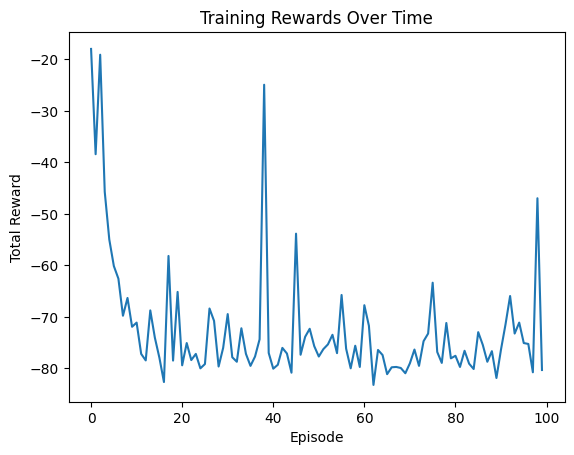

In [72]:
    import matplotlib.pyplot as plt
    if 'training_rewards' in locals() and training_rewards:
        plt.plot(training_rewards)
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("Training Rewards Over Time")
        plt.show()